In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)
EbNodB_range = list(np.arange(-2,8+0.5,0.5))

M: 256 	 n: 4 k: 8 R:  1.0
(150000, 256)
25 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
212 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

Epoch 1/50
150000/150000 [==============================] - 10s 65us/step - loss: 2.7299
Epoch 2/50
150000/150000 [==============================] - 7s 46us/step - loss: 0.2515
Epoch 3/50
150000/150000 [==============================] - 7s 46us/step - loss: 0.0809
Epoch 4/50
150000/150000 [==============================] - 6s 41us/step - loss: 0.0462
Epoch 5/50
150000/150000 [==============================] - 7s 49us/step - loss: 0.0317: 1s
Epoch 6/50
150000/150000 [==============================] - 6s 40us/step - loss: 0.0244
Epoch 7/50
150000/150000 [==============================] - 6s 37us/step - loss: 0.0199
Epoch 8/50
150000/150000 [==============================] - 5s 36us/step - loss: 0.0171
Epoch 9/50
150000/150000 [==============================] - 5s 33us/step - loss: 0.0147
Epoch 10/50
150000/150000 [==============================] - 7s 44us/step - loss: 0.0130
Epoch 11/50
150000/150000 [==============================] - 7s 45us/step - loss: 0.0123
Epoch 12/50
150000/150000

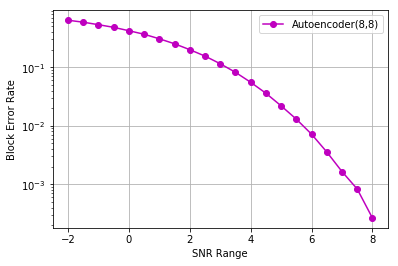

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 256
k = np.log2(M)
k = int(k)
n_channel = 4
R = k/(2*n_channel)
print('M:',M,'\t','n:',n_channel,'k:',k,'R: ',R)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))

#generating data of size N
N = 150000
label = np.random.randint(M,size=N)

# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
    
# checking data shape
data = np.array(data)
print (data.shape)

# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])
    
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded3 = Lambda(lambda x: np.sqrt(2*n_channel)*K.l2_normalize(x,axis=1))(encoded1)

# Gaussian Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel1 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

# Reciever Layer
decoded = Dense(M, activation='relu')(channel1)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.001)
sgd = SGD(lr=0.02)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=1024)

# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

# generating data for checking BER
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)


'''
AutoEncoder(8,8)
'''

ber_auto_8_8 = [None]*len(EbNodB_range)
for i in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std*np.random.randn(nn,2*n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal+noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber_auto_8_8[i] = no_errors / nn 
    print ('SNR:',EbNodB_range[i],'BER:',ber_auto_8_8[i])
    
#plot bler vs snr
plt.plot(EbNodB_range, ber_auto_8_8, 'mo-',label='Autoencoder(8,8)')

plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()




M: 4 	 n: 1 k: 2 R:  1.0
(150000, 4)
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
2 [0. 0. 1. 0.]
2 [0. 0. 1. 0.]
3 [0. 0. 0. 1.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)            

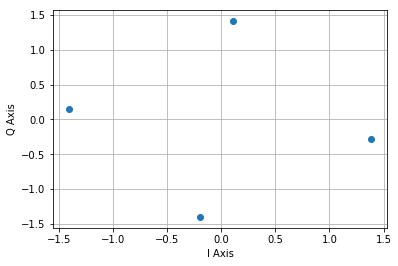

SNR: -2.0 BER: 0.2494
SNR: -1.5 BER: 0.22414666666666666
SNR: -1.0 BER: 0.20042666666666667
SNR: -0.5 BER: 0.17830666666666667
SNR: 0.0 BER: 0.15407333333333334
SNR: 0.5 BER: 0.13238
SNR: 1.0 BER: 0.11215333333333333
SNR: 1.5 BER: 0.09386
SNR: 2.0 BER: 0.07481333333333333
SNR: 2.5 BER: 0.05995333333333333
SNR: 3.0 BER: 0.04788666666666667
SNR: 3.5 BER: 0.03562666666666667
SNR: 4.0 BER: 0.02684
SNR: 4.5 BER: 0.01840666666666667
SNR: 5.0 BER: 0.013286666666666667
SNR: 5.5 BER: 0.00796
SNR: 6.0 BER: 0.005213333333333334
SNR: 6.5 BER: 0.0030533333333333332
SNR: 7.0 BER: 0.00188
SNR: 7.5 BER: 0.00102
SNR: 8.0 BER: 0.0002866666666666667


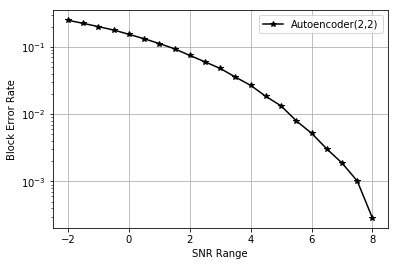

In [4]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 4
k = np.log2(M)
k = int(k)
n_channel = 1
R = k/(2*n_channel)
tx_power = 2
print('M:',M,'\t','n:',n_channel,'k:',k,'R: ',R)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

#generating data of size N
N = 150000
label = np.random.randint(M,size=N)

# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
    
# checking data shape
data = np.array(data)
print (data.shape)

# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])
    
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded3 = Lambda(lambda x: np.sqrt(2*n_channel)*K.l2_normalize(x,axis=1))(encoded1)

# Gaussian Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel1 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)

# Reciever Layer
decoded = Dense(M, activation='relu')(channel1)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

# traning auto encoder
autoencoder.fit(data, data,
                epochs=50,
                batch_size=1024)

# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

# generating data for checking BER
N = 150000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

# ploting constellation diagram
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

'''
AutoEncoder(2,2)
'''
ber = [None]*len(EbNodB_range)
for i in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std*np.random.randn(nn,2*n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal+noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[i] = no_errors / nn 
    print ('SNR:',EbNodB_range[i],'BER:',ber[i])
    
#plot bler vs snr
plt.plot(EbNodB_range, ber, 'k*-',label='Autoencoder(2,2)')

plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()




In [5]:
#functions for bler vs SNR for uncoded_BPSK
def generate_test_data(M):
    test_data = np.random.randint(M,size=N)
    return test_data

def encode_uncoded_bpsk(test_data,n):
    encoded = []
    for i in test_data:
        elem = bin(i)[2:].zfill(n)
        if n==2:
            encoded.append([[int(elem[-2])],[int(elem[-1])]])    
        elif n==4:
            encoded.append([[int(elem[-4])],[int(elem[-3])],[int(elem[-2])],[int(elem[-1])]])
        else:
            encoded.append([[int(elem[-8])],[int(elem[-7])],[int(elem[-6])],[int(elem[-5])],[int(elem[-4])],[int(elem[-3])],[int(elem[-2])],[int(elem[-1])]])
    encoded = np.array(encoded)
    encoded = encoded.reshape([N,n])
    return 2*np.array(encoded)-1
    
def add_noise(encoded,n,EbNodB):
    EbNo=10.0**(EbNodB/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    #print("noise_std: "+str(noise_std))
    noise = noise_std*np.random.randn(N,n)
    final_signal = encoded+noise
    return final_signal
    
def decode_uncoded_bpsk(final,M,n):
    y_d=[]
    for i in final:
        i_d = []
        for j in i:
            j_d = '1' if j>0 else '0'
            i_d.append(j_d)
        i_d = ''.join(i_d)
        y_d.append(int(i_d,2)) 
    return np.array(y_d)

def find_bler(x,y):
    no_errors = np.count_nonzero(x - y)
    bler = no_errors / N 
    return bler

In [6]:
'''
Uncoded BPSK (2,2)
'''
N=150000
M=4
n=2
test_data= generate_test_data(M)
bler_array_uncoded_2_2 = [None]*len(EbNodB_range)
#print("generated data:"+str(test_data))
encoded = encode_uncoded_bpsk(test_data,n)
#print("encoded data:"+str(encoded))
for i in range(0,len(EbNodB_range)):
    final_signal = add_noise(encoded,n,EbNodB=EbNodB_range[i])
    decoded = decode_uncoded_bpsk(final_signal,M,n)
    bler_array_uncoded_2_2[i] = find_bler(test_data,decoded)
    print("SNR: "+str(EbNodB_range[i])+" BLER: "+str(bler_array_uncoded_2_2[i]))
    


SNR: -2.0 BLER: 0.24552666666666667
SNR: -1.5 BLER: 0.22302666666666668
SNR: -1.0 BLER: 0.19663333333333333
SNR: -0.5 BLER: 0.17415333333333333
SNR: 0.0 BLER: 0.15091333333333334
SNR: 0.5 BLER: 0.13015333333333334
SNR: 1.0 BLER: 0.10902
SNR: 1.5 BLER: 0.09072666666666666
SNR: 2.0 BLER: 0.07327333333333333
SNR: 2.5 BLER: 0.058493333333333335
SNR: 3.0 BLER: 0.04536
SNR: 3.5 BLER: 0.03405333333333333
SNR: 4.0 BLER: 0.024966666666666668
SNR: 4.5 BLER: 0.017286666666666665
SNR: 5.0 BLER: 0.012353333333333332
SNR: 5.5 BLER: 0.0076
SNR: 6.0 BLER: 0.004733333333333333
SNR: 6.5 BLER: 0.003013333333333333
SNR: 7.0 BLER: 0.00154
SNR: 7.5 BLER: 0.0008133333333333333
SNR: 8.0 BLER: 0.0004333333333333333


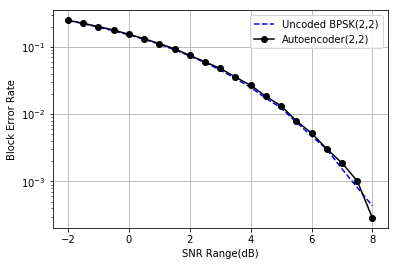

In [10]:
#plot bler vs snr
plt.plot(EbNodB_range, bler_array_uncoded_2_2, 'b--',label='Uncoded BPSK(2,2)')
plt.plot(EbNodB_range, ber, 'ko-',label='Autoencoder(2,2)')

plt.yscale('log')
plt.xlabel('SNR Range(dB)')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()


